# Data Rebalancing

In [8]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import pickle

# from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.metrics import make_scorer # to define own metrics
from sklearn.model_selection import KFold, GridSearchCV, cross_validate, cross_val_score

from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline

In [19]:
import warnings
warnings.filterwarnings("ignore")  # silence warnings

In [10]:
churn_train_encoded = pd.read_pickle('data/churn_train_encoded.pkl')
churn_test_encoded = pd.read_pickle('data/churn_test_encoded.pkl')

churn_train_encoded.head()

,customer_id,customer_age,customer_number_of_dependents,customer_education,customer_salary_range,customer_relationship_length,customer_available_credit_limit,total_products,period_inactive,contacts_in_last_year,...,average_utilization,customer_gender_M,customer_gender_Unknown,customer_civil_status_Married,customer_civil_status_Single,customer_civil_status_Unknown,credit_card_classification_Gold,credit_card_classification_Platinum,credit_card_classification_Silver,account_status_1
4694,799562,50.0,2.0,2.0,1.0,37.0,13384.0,1.0,3.0,2.0,...,0.000,0,0,1,0,0,0,0,1,0
1263,282706,52.0,1.0,2.0,5.0,36.0,31945.0,4.0,3.0,5.0,...,0.050,1,0,0,0,0,0,0,0,0
4427,837683,46.0,3.0,1.0,3.0,36.0,5489.0,5.0,1.0,2.0,...,0.217,1,0,0,1,0,0,0,0,0
8746,384742,53.0,5.0,0.0,4.0,48.0,9517.0,6.0,1.0,0.0,...,0.196,1,0,1,0,0,0,0,0,0
4386,618362,59.0,0.0,4.0,2.0,53.0,4241.0,3.0,2.0,3.0,...,0.000,1,0,1,0,0,0,0,0,0


## Application of sample rebalancing methods
`Caution!!!` Rebalancing technique should be used `ONLY` on the `TRAINING DATA SET` !!!

Similarly like data transformations - it makes no sense in applying transformations first and dividing the transformed data in the training and testing dataset - this is `information leakage`.

It makes no sense to create instances based on the current minority class and then exclude an instance for validation, pretending we did not generate it using data that is still in the training set.

In [13]:
# lets remind the frequencies of the outcome variable in the training sample

print('Original frequencies of the outcome variable in the training sample:')
print(churn_train_encoded['account_status_1'].value_counts())
print('\nOriginal percentages of the outcome variable in the training sample: ')
print(churn_train_encoded['account_status_1'].value_counts(normalize = True))

# 16% of clients churned

Original frequencies of the outcome variable in the training sample:
account_status_1
0    5949
1    1139
Name: count, dtype: int64

Original percentages of the outcome variable in the training sample: 
account_status_1
0    0.839306
1    0.160694
Name: proportion, dtype: float64


---
### Down-sampling
---

In [29]:
# lets check how random down-sampling works

churn_train_X = churn_train_encoded.drop(['account_status_1', 'customer_id'], axis = 1)
churn_train_y = churn_train_encoded['account_status_1']

# create the undersampler
sampling_ = RandomUnderSampler(random_state = 123)

# Fit and resample - .fit_resample() similar to .fit_transform() in sklearn
X_down, y_down = sampling_.fit_resample(churn_train_X, churn_train_y)

churn_train_down = pd.concat([X_down, y_down], axis = 1)

# check the distribution of classes after downsampling
print('Frequencies of the outcome variable in the training sample after downsampling:')
print(churn_train_down['account_status_1'].value_counts())
print('\nPercentages of the outcome variable in the training sample after downsampling:')
print(churn_train_down['account_status_1'].value_counts(normalize=True))

Frequencies of the outcome variable in the training sample after downsampling:
account_status_1
0    1139
1    1139
Name: count, dtype: int64

Percentages of the outcome variable in the training sample after downsampling:
account_status_1
0    0.5
1    0.5
Name: proportion, dtype: float64


---
### Up-sampling
---

In [31]:
# lets check how random up-sampling works - same syntax as above

# create the oversampler
sampling_2 = RandomOverSampler(random_state = 123)

# Fit and resample
X_up, y_up = sampling_2.fit_resample(churn_train_X, churn_train_y)

# combine X_up and y_up back into single DataFrame
churn_train_up = pd.concat([X_up, y_up], axis=1)

# check the distribution of classes after upsampling
print('Frequencies of the outcome variable in the training sample after upsampling:')
print(churn_train_up['account_status_1'].value_counts())
print('\nPercentages of the outcome variable in the training sample after upsampling:')
print(churn_train_up['account_status_1'].value_counts(normalize=True))

Frequencies of the outcome variable in the training sample after upsampling:
account_status_1
0    5949
1    5949
Name: count, dtype: int64

Percentages of the outcome variable in the training sample after upsampling:
account_status_1
0    0.5
1    0.5
Name: proportion, dtype: float64


---
### SMOTE
---

In [34]:
# one of the most common non-standard up-sampling methods is SMOTE

# create the oversampler
sampling_3 = SMOTE(random_state = 123) # optimal argument: k_neighbors = 5 by default

# fit and resample
X_sm, y_sm = sampling_3.fit_resample(churn_train_X, churn_train_y)

# combine X_up and y_up back into a single DataFrame
churn_train_SMOTE = pd.concat([X_sm, y_sm], axis = 1)

# check the distribution of classes after SMOTE
print('Frequencies of the outcome variable in the training sample after SMOTE:')
print(churn_train_SMOTE['account_status_1'].value_counts())
print('\nPercentages of the outcome variable in the training sample after SMOTE:')
print(churn_train_SMOTE['account_status_1'].value_counts(normalize=True))

Frequencies of the outcome variable in the training sample after SMOTE:
account_status_1
0    5949
1    5949
Name: count, dtype: int64

Percentages of the outcome variable in the training sample after SMOTE:
account_status_1
0    0.5
1    0.5
Name: proportion, dtype: float64


---
### Tomek Links
---

In [39]:
# Tomek Links removes examples that are "tomek links" - pairs of samples
# from different classes that are very close together in feature space.
# They are generally considered noise or bordline points.

# Down-sampling is achieved by removing the majority-class samples
# in each tomek link pair, thus cleaning up the decision boundary.

# create the undersampler
sampling_4 = TomekLinks()

# fit and resample
X_tl, y_tl = sampling_4.fit_resample(churn_train_X, churn_train_y)

# combine X_tl and y_tl back into single DataFrame
churn_train_TL = pd.concat([X_tl, y_tl], axis = 1)

# check the distribution of classes after Tomek Links
print("Frequencies of the outcome variable in the training sample after Tomek Links:")
print(churn_train_TL['account_status_1'].value_counts())
print("\nPercentages of the outcome variable in the training sample after Tomek Links:")
print(churn_train_TL['account_status_1'].value_counts(normalize = True))

Frequencies of the outcome variable in the training sample after Tomek Links:
account_status_1
0    5688
1    1139
Name: count, dtype: int64

Percentages of the outcome variable in the training sample after Tomek Links:
account_status_1
0    0.833162
1    0.166838
Name: proportion, dtype: float64


---
### SMOTETomek
---

In [42]:
# In some cases, you want to oversample the minority class
# and clean up the majority class simultaneously

# Combination of SMOTE and Tomek Links (SMOTETomek)
# - applies SMOTE first, then uses Tomek Links
# to remove borderline majority samples

# create the undersampler
sampling_5 = SMOTETomek(random_state = 123)

# fit and resample
X_stl, y_stl = sampling_5.fit_resample(churn_train_X, churn_train_y)

# combine X_stl1 and y_stl1 back into a single DataFrame
churn_train_STL = pd.concat([X_stl, y_stl], axis=1)

# Check distribution of classes after SMOTETomek
print("Frequencies of the outcome variable in the training sample after SMOTETomek:")
print(churn_train_STL['account_status_1'].value_counts())
print("\nPercentages of the outcome variable in the training sample after SMOTETomek:")
print(churn_train_STL['account_status_1'].value_counts(normalize = True))

Frequencies of the outcome variable in the training sample after SMOTETomek:
account_status_1
0    5742
1    5742
Name: count, dtype: int64

Percentages of the outcome variable in the training sample after SMOTETomek:
account_status_1
0    0.5
1    0.5
Name: proportion, dtype: float64


---
### ADASYN
---

In [45]:
# lets also consider ADASYN

# create the undersampler
sampling_6 = ADASYN(random_state = 123)

X_ada, y_ada = sampling_6.fit_resample(churn_train_X, churn_train_y)

churn_train_ADA = pd.concat([X_ada, y_ada], axis = 1)

# Check distribution of classes after ADASYN
print("Frequencies of the outcome variable in the training sample after ADASYN:")
print(churn_train_ADA['account_status_1'].value_counts())
print("\nPercentages of the outcome variable in the training sample after ADASYN:")
print(churn_train_ADA['account_status_1'].value_counts(normalize = True))

Frequencies of the outcome variable in the training sample after ADASYN:
account_status_1
1    6001
0    5949
Name: count, dtype: int64

Percentages of the outcome variable in the training sample after ADASYN:
account_status_1
1    0.502176
0    0.497824
Name: proportion, dtype: float64


## Applications of various rebalancing techniques within cross-validation of logistic regression

In [52]:
# lets check how various rebalancing methods influence model performance on a NEW DATASET

# to avoid looking into the test data we need to apply cross-validation

# lets start with a benchmark - logistic regression with no rebalancing
# and assess its performance on a new data with the use of 5-Fold cross-validation

cv5 = KFold(
    n_splits = 5,
    shuffle = True,
    random_state = 123
)

# and use a function cross_val_score()
# - however, it allows for only one scoring metric at a time

cross_val_score(
    estimator = LogisticRegression(
        penalty = None,
        max_iter = 1000,
        tol = 0.01
    ),
    X = churn_train_X,
    y = churn_train_y,
    cv = cv5,
    scoring = 'balanced_accuracy',
    n_jobs = -1
).mean()

0.7096573172432666

In [54]:
# using a wide range of metrics (also level-specific)

# defining custom metrics for individual levels
def recall_for_class_0(y_true, y_pred):
    return recall_score(y_true, y_pred, pos_label = 0)

def recall_for_class_1(y_true, y_pred):
    return recall_score(y_true, y_pred, pos_label = 1)

def precision_for_class_0(y_true, y_pred):
    return precision_score(y_true, y_pred, pos_label = 0)

def precision_for_class_1(y_true, y_pred):
    return precision_score(y_true, y_pred, pos_label = 1)

def f1_for_class_0(y_true, y_pred):
    return f1_score(y_true, y_pred, pos_label = 0)

def f1_for_class_1(y_true, y_pred):
    return f1_score(y_true, y_pred, pos_label = 1)


# and lets put them together into a list of scoring metrics
scoring_full = {
    'accuracy': 'accuracy',
    # add custom scorers for each class
    'recall_class_0': make_scorer(recall_for_class_0),
    'recall_class_1': make_scorer(recall_for_class_1),
    'balanced_accuracy': 'balanced_accuracy', # or alternatively 'recall_macro'
    'precision_class_0': make_scorer(precision_for_class_0),
    'precision_class_1': make_scorer(precision_for_class_1),
    'f1_class_0': make_scorer(f1_for_class_0),
    'f1_class_1': make_scorer(f1_for_class_1),
    'roc_auc': 'roc_auc'
}

# and apply it to our model - we need to use another function than before
# - cross_validation() which allows for multiple scoring metrics
# - it returns a dictionary with all the metrics for each fold

performance_benchmark = cross_validate(
    estimator = LogisticRegression(
        penalty = None,
        max_iter = 1000,
        tol = 0.01
    ),
    X = churn_train_X,
    y = churn_train_y,
    cv = cv5,
    scoring = scoring_full,
    n_jobs = -1,
    return_train_score = False # set True if you also want train scores
)

# performance_benchmark is a dictionary; lets convert it to a DataFrame
performance_benchmark_df = pd.DataFrame(performance_benchmark)
performance_benchmark_df

# results for folds are in subsequent rows

,fit_time,score_time,test_accuracy,test_recall_class_0,test_recall_class_1,test_balanced_accuracy,test_precision_class_0,test_precision_class_1,test_f1_class_0,test_f1_class_1,test_roc_auc
0,0.452593,0.057829,0.876587,0.961116,0.451064,0.706090,0.898104,0.697368,0.928542,0.547804,0.862981
1,0.498962,0.038543,0.879408,0.962312,0.437500,0.699906,0.901176,0.685315,0.930741,0.534060,0.873374
2,0.467296,0.019254,0.894217,0.973289,0.463636,0.718463,0.908100,0.761194,0.939565,0.576271,0.891896
3,0.299320,0.027570,0.892731,0.968569,0.451923,0.710246,0.911284,0.712121,0.939054,0.552941,0.892242
4,0.501678,0.067604,0.879323,0.970815,0.456349,0.713582,0.891956,0.771812,0.929716,0.573566,0.877076


In [56]:
# average of each column (apart from the first two) across all folds
print('\nAverage over all folds')
print(performance_benchmark_df.iloc[:, 2:].mean())

# not very good in predicting churning clients:
# - recall for class 1 = 0.46, precision for 1s also low


Average over all folds
test_accuracy             0.884453
test_recall_class_0       0.967220
test_recall_class_1       0.452094
test_balanced_accuracy    0.709657
test_precision_class_0    0.902124
test_precision_class_1    0.725562
test_f1_class_0           0.933524
test_f1_class_1           0.556928
test_roc_auc              0.879514
dtype: float64


In [60]:
# lets check how various rebalancing methods influence model performance
# on a NEW DATASET compared to our benchmark

# to avoid looking into the test data we need to apply cross-validation

# IMPORTANT! As rebalancing is applied to TRAIN data only,
# it has to be done INDEPENDENTLY in each step of cross-validation!

# Therefore we need to put it into the Pipeline

# lets try all the methods presented above applied to a logistic regression:
# - rebalancing methods: none, down, up, SMOTE, ADASYN, Tomeklinks, SMOTETomek

# -------------------------------------------------------------------------------

# define the pipeline
#    step 1: sampler (to handle imbalance)
#    step 2: logistic regression classifier

pipe = Pipeline(
    [
        # placeholder step (will be replaced in param grid)
        ('sampler', RandomUnderSampler()),
        ('model', LogisticRegression(
            penalty = None,
            max_iter = 1000, # max_iter = 1000 to avoid convergence warnings
            tol = 0.01 
        ))
    ]
)


# ----------------------------------------------------------------------------
# define the parameter grid for GridSearchCV
# here our "hyperparameter" is the resampling method

param_grid = {
    'sampler': [
        # "passthrough" = skip this step, leave the data as is
        'passthrough', # no rebalancing
        RandomUnderSampler(random_state = 123),
        RandomOverSampler(random_state = 123),
        SMOTE(random_state = 123),
        ADASYN(random_state = 123),
        TomekLinks(),
        SMOTETomek(random_state = 123)
    ]
}

In [62]:
# -------------------------------------------------------------------------------
# Set up GridSearchCV, which also allows for multiple metrics,
# but one has to be indicated in the refit= argument
# (based on which the best model is selected)

performance_rebalancing = GridSearchCV(
    estimator = pipe, # model
    param_grid = param_grid, # we defined earlier
    # we use all the metrics defined above
    scoring = scoring_full,
    # but we need to indicate one of them in the refit= argument
    # (based on which the best model is selected)
    refit = 'balanced_accuracy',
    cv = cv5, # CV5 - defined above
    n_jobs = -1
)
# -------------------------------------------------------------------------------

performance_rebalancing.fit(churn_train_X, churn_train_y)

# best parameters found for the refit metric (balanced accuracy)
print('Best Params:', performance_rebalancing.best_params_)
print('Best_Score:', performance_rebalancing.best_score_)

Best Params: {'sampler': RandomOverSampler(random_state=123)}
Best_Score: 0.7950377043904548


In [64]:
# Collect and inspect results in more readable format
# Convert the cv_results_ to a DataFrame for better readability
performance_rebalancing_df = pd.DataFrame(performance_rebalancing.cv_results_)

performance_rebalancing_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_sampler,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,...,std_test_f1_class_1,rank_test_f1_class_1,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,split3_test_roc_auc,split4_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc
0,0.546702,0.067878,0.032403,0.002153,passthrough,{'sampler': 'passthrough'},0.876587,0.879408,0.894217,0.892731,...,0.015957,2,0.862981,0.873374,0.891896,0.892242,0.877076,0.879514,0.011246,1
1,0.308407,0.033966,0.039205,0.002248,RandomUnderSampler(random_state=123),{'sampler': RandomUnderSampler(random_state=123)},0.789140,0.774330,0.803949,0.783345,...,0.023795,7,0.858495,0.863839,0.888192,0.879398,0.873551,0.872695,0.010638,3
2,1.119564,0.036300,0.044060,0.007486,RandomOverSampler(random_state=123),{'sampler': RandomOverSampler(random_state=123)},0.779972,0.781382,0.805360,0.788285,...,0.024126,6,0.857272,0.866363,0.886053,0.880869,0.872863,0.872684,0.010230,4
3,1.265661,0.044936,0.043243,0.003906,SMOTE(random_state=123),{'sampler': SMOTE(random_state=123)},0.791255,0.787024,0.824401,0.799577,...,0.028387,3,0.857898,0.854212,0.886474,0.872208,0.870454,0.868249,0.011462,6
4,1.207444,0.061921,0.039740,0.004440,ADASYN(random_state=123),{'sampler': ADASYN(random_state=123)},0.791961,0.787024,0.806065,0.796048,...,0.018710,5,0.856891,0.861835,0.883875,0.870912,0.867675,0.868238,0.009184,7


In [80]:
# keep just the columns that start with "mean_test_"
cols_to_keep = [
    col for col in performance_rebalancing_df.columns
    if col.startswith('mean_test_')
]

# concatenate the string 'params' with the list of columns to keep
subset_cols = ['params'] + cols_to_keep

# sort by 'rank_test_balanced_accuracy'
result_df = performance_rebalancing_df[subset_cols].sort_values(
    by = 'mean_test_balanced_accuracy',
    ascending = False
)

result_df.head(7)

# each of the rebalancing methods improves balanced accuracy
# two best approaches: over- and under-sampling allow to obtain almost equal recall
# for both classes

,params,mean_test_accuracy,mean_test_recall_class_0,mean_test_recall_class_1,mean_test_balanced_accuracy,mean_test_precision_class_0,mean_test_precision_class_1,mean_test_f1_class_0,mean_test_f1_class_1,mean_test_roc_auc
2,{'sampler': RandomOverSampler(random_state=123)},0.790774,0.789096,0.800979,0.795038,0.953702,0.420629,0.863575,0.551000,0.872684
1,{'sampler': RandomUnderSampler(random_state=123)},0.790774,0.790176,0.795927,0.793052,0.952622,0.420816,0.863721,0.549628,0.872695
4,{'sampler': ADASYN(random_state=123)},0.796135,0.799166,0.781468,0.790317,0.950035,0.426497,0.868067,0.551349,0.868238
3,{'sampler': SMOTE(random_state=123)},0.803754,0.811297,0.765259,0.788278,0.947349,0.437565,0.873985,0.556067,0.868249
6,{'sampler': SMOTETomek(random_state=123)},0.802767,0.810823,0.762434,0.786629,0.946662,0.435767,0.873382,0.553617,0.869508
5,{'sampler': TomekLinks()},0.883607,0.962351,0.472219,0.717285,0.904954,0.706195,0.932756,0.565825,0.878062
0,{'sampler': 'passthrough'},0.884453,0.967220,0.452094,0.709657,0.902124,0.725562,0.933524,0.556928,0.879514


In [86]:
# maybe it will be more readable on the plot

# lets plot all the metrics for all the methods

# we will use a line plot, where 'params' will be on the x-axis
# and all the metrics on the y-axis

# we need to melt the DataFrame to long format for seaborn
# (so that each metric is in a separate row)
melted_df = pd.melt(
    result_df, 
    id_vars = ['params'], 
    value_vars = [col for col in result_df.columns if col.startswith('mean_test_')],
    var_name = 'metric',
    value_name = 'value')

melted_df.head()
# pd.melt() reshapes a wide DataFrame into a long (tidy) format.

,params,metric,value
0,{'sampler': RandomOverSampler(random_state=123)},mean_test_accuracy,0.790774
1,{'sampler': RandomUnderSampler(random_state=123)},mean_test_accuracy,0.790774
2,{'sampler': ADASYN(random_state=123)},mean_test_accuracy,0.796135
3,{'sampler': SMOTE(random_state=123)},mean_test_accuracy,0.803754
4,{'sampler': SMOTETomek(random_state=123)},mean_test_accuracy,0.802767


In [88]:
# lets make some cleaning of the labels

# Remove the 'mean_test_' prefix from the metric names for better readability
melted_df['metric'] = melted_df['metric'].str.replace('mean_test_', '')

# Remove the '(random_state=123)' prefix from the parameter names for better readability
# here we need to use regex approach as parentheses in strings can be treated
# as special characters during string replacement
melted_df['params'] = melted_df['params'].astype(str).str.replace(r'\(random_state=123\)', '', regex=True)

melted_df.head()

,params,metric,value
0,{'sampler': RandomOverSampler},accuracy,0.790774
1,{'sampler': RandomUnderSampler},accuracy,0.790774
2,{'sampler': ADASYN},accuracy,0.796135
3,{'sampler': SMOTE},accuracy,0.803754
4,{'sampler': SMOTETomek},accuracy,0.802767


In [90]:
# Remove the string "{'sampler': " from the parameter names
melted_df['params'] = melted_df['params'].str.replace("{'sampler': ", '')

# Remove the string "}" from the parameter names
melted_df['params'] = melted_df['params'].str.replace("}", '')

# Remove the 'passthrough' from the parameter names
melted_df['params'] = melted_df['params'].str.replace('passthrough', 'No rebalancing')

melted_df.head()

,params,metric,value
0,RandomOverSampler,accuracy,0.790774
1,RandomUnderSampler,accuracy,0.790774
2,ADASYN,accuracy,0.796135
3,SMOTE,accuracy,0.803754
4,SMOTETomek,accuracy,0.802767


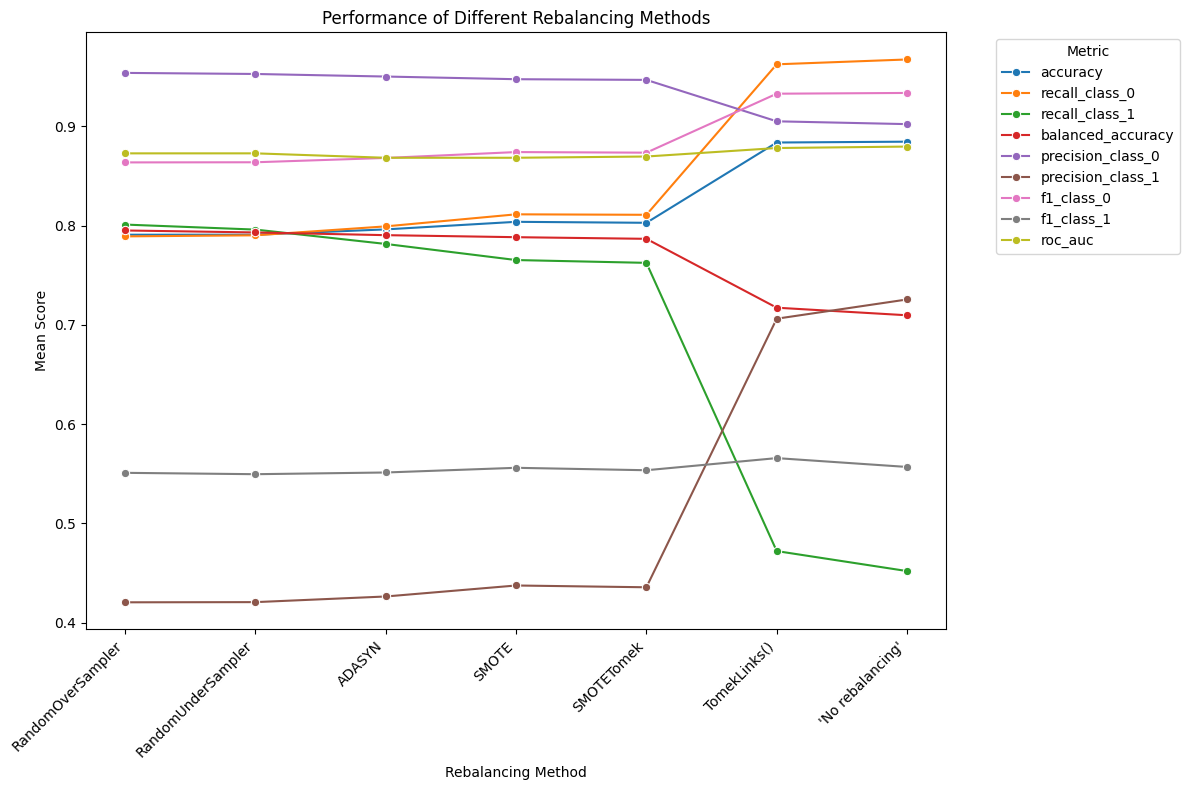

In [92]:
# and finally plot it

plt.figure(figsize=(12, 8))
sns.lineplot(data=melted_df, x='params', y='value', hue='metric', marker='o')
plt.xticks(rotation=45, ha='right')
plt.title('Performance of Different Rebalancing Methods')
plt.xlabel('Rebalancing Method')
plt.ylabel('Mean Score')
plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [94]:
# ROC AUC is not very sensitive to class imbalance
# but balanced accuracy and other metrics depending
# on the cutoff point can be improved by rebalancing

# interestingly, in our case the BA improves the most 
# with simple random up-sampling, down-sampling and SMOTE

## Models Comparison

In [113]:
# lets compare in a similar way selected models which we applied
# so far to the 'churn' dataset

model_churn_knn = pickle.load(open('data/churn_model_knn.pkl', 'rb'))
model_churn_svm_poly = pickle.load(open('data/churn_model_svm_poly.pkl', 'rb'))
model_churn_svm_rbf = pickle.load(open('data/churn_model_svm_rbf.pkl', 'rb'))

# todays benchmarks
model_churn_logreg = LogisticRegression(penalty = None,
                                        max_iter = 1000, 
                                        tol = 0.01)

model_churn_logreg_oversample = Pipeline([
    ('sampler', RandomOverSampler(random_state = 123)),
    ('model', LogisticRegression(penalty = None,
                                 max_iter = 1000, 
                                 tol = 0.01))
])

In [115]:
# apply the same cross-validation procedure to all models
# and collect the results in a dictionary

# we will use the same scoring metrics as before (scoring_full)
# and the same cv5

# lets create a dictionary with all the models
models = {
    'Logistic Regression': model_churn_logreg,
    'Logistic Regression (Oversample)': model_churn_logreg_oversample,
    'SVMpoly': model_churn_svm_poly,
    'SVMrbf': model_churn_svm_rbf,
    'KNN': model_churn_knn
}

# Create an empty dictionary to store average results
average_scores = {}

# Loop over the models

# .items() gives both key and values of the dictionary
    # that is why we have to use the second element of the tuple
    # (model_name, model)
for model_name, model in models.items():
    # Run cross-validation
    cv_results = cross_validate(
        estimator = model,
        X = churn_train_X,
        y = churn_train_y,
        cv = cv5,
        scoring = scoring_full,
        return_train_score = False,
        n_jobs = -1
    )

    # Calculate average scores for each metric
    averages = {}
    
    for metric_name, scores in cv_results.items():
        if metric_name.startswith('test_'):
            averages[metric_name] = scores.mean()
    
    # Store the average scores in the dictionary
    average_scores[model_name] = averages

# Convert results to a DataFrame
performance_df = pd.DataFrame.from_dict(average_scores, orient='index')

performance_df.head()

# it may take several minutes to run

AttributeError: 'Pipeline' object has no attribute 'transform_input'

In [117]:
# lets remove the prefix 'test_' from the column names

performance_df.columns = performance_df.columns.str.replace('test_', '')

# and plot the results

plt.figure(figsize=(12, 8))
sns.lineplot(data=performance_df, marker = 'o', 
             dashes = False) # forces solid lines
plt.xticks(rotation=45, ha='right')
plt.title('Performance of Different Models')
plt.xlabel('Model')
plt.ylabel('Mean Score')
plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

NameError: name 'performance_df' is not defined